# Load libraries

In [2]:
import pickle, logging
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

# Load data

In [3]:
reviews=pd.read_csv('../data/amazon_reviews_us_Apparel_v1_00.tsv.gz.tsv',sep='\t')

In [4]:
reviews['label']=(reviews['verified_purchase']=='y').astype(int)

In [5]:
reviews=reviews.dropna()

In [44]:
reviews['label'].mean()

0.8995045187685107

# Split data

In [60]:
def split_data(df,test_size):
    return df[:test_size],df[:test_size]

In [61]:
test, train=split_data(df=reviews,test_size=10000)

In [68]:
def tokenize_data(train,test):
    X_train, X_test, Y_train, Y_test = train['review_body'].values,\
                                                    test['review_body'].values,\
                                                    train['label'].values,\
                                                    test['label'].values
    for label in [Y_train, Y_test]:
          logging.debug("label mean: {0}".format(label.mean()))
    tokenizer = Tokenizer(num_words= 50000)
    tokenizer.fit_on_texts(X_train)
    X_train_tok = tokenizer.texts_to_sequences(X_train)
    X_test_tok = tokenizer.texts_to_sequences(X_test)
    max_review_length = 600
    X_train_pad = sequence.pad_sequences(X_train_tok, maxlen=max_review_length)
    X_test_pad = sequence.pad_sequences(X_test_tok, maxlen=max_review_length)
    return X_train_pad, X_test_pad, Y_train, Y_test

array([1, 1, 1, ..., 1, 1, 0])

# Re-samples

In [7]:
def get_samples(df, n):
    samples=df[:n]
    print('Initial label mean: {0}'.format(samples['label'].mean()))
    counts=samples.groupby('label')['label'].count().to_dict()
    sorted_counts = sorted(counts.items(), key=lambda kv: kv[1])
    undersample = samples[samples['label'] == sorted_counts[1][0]].sample(sorted_counts[0][1])
    samples=pd.concat([undersample, samples[samples['label'] == sorted_counts[0][0]]])
    print('Undersampled label mean: {0}'.format(samples['label'].mean()))
    return samples

In [8]:
def clean_text(df,features=['review_body','label']):
    df['review_body'].replace(regex=[r'([^a-z\s]+)'], value='', inplace=True)
    return df[features].copy()

In [62]:
samples=get_samples(train, n=5000)
samples=clean_text(samples)

Initial label mean: 0.6492
Undersampled label mean: 0.5


In [77]:
# df=pd.DataFrame({'weight':s})
# df['word'] = df.index
# df=df.set_index('weight')
# df.to_csv("words.csv")

## Save/Load the clean dataframe

In [32]:
# size=len(reviews)
# samples=get_samples(reviews, n=size)
# samples=clean_text(samples)
# saved_dataframe='results/clean_data_frame.p'
# pickle.dump( samples, open( saved_dataframe, "wb" ) )
# samples= pickle.load( open( saved_dataframe, "rb" ) )

Initial label mean: 0.8995045187685107
Undersampled label mean: 0.5


# Compile models

In [81]:
models=[]

max_review_length = 600
embedding_vector_length = 32
top_words = 50000
models.append(Sequential())
model=models[-1]
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [82]:
embedding_vector_length = 40
models.append(Sequential())
model=models[-1]
model.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [83]:
models.append(Sequential())
model=models[-1]
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(GRU(256, return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [88]:
st = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tb=tf.keras.callbacks.TensorBoard(log_dir='logs')

In [89]:
!rm -rf logs

In [90]:
X_train_pad, X_test_pad, Y_train, Y_test=tokenize_data(train=samples,test=test)

In [92]:
for model in models:
    model.fit(X_train_pad, Y_train, epochs=20, callbacks=[st], batch_size=64,validation_data=(X_test_pad,Y_test))
    # Final evaluation of the model on test data
    scores = model.evaluate(X_test_pad, Y_test, verbose=0)
    print("loss: {0:2.2f}, accuracy {1:2.2f}".format(scores[0],scores[1]))

Train on 3508 samples, validate on 10000 samples
Epoch 1/20
3508/3508 [==============================] - 25s 7ms/sample - loss: 0.0654 - accuracy: 0.9786 - recall_4: 0.9840 - precision_4: 0.9735 - val_loss: 0.7099 - val_accuracy: 0.8023 - val_recall_4: 0.7899 - val_precision_4: 0.9308
Epoch 2/20
3508/3508 [==============================] - 25s 7ms/sample - loss: 0.0638 - accuracy: 0.9800 - recall_4: 0.9886 - precision_4: 0.9720 - val_loss: 0.7297 - val_accuracy: 0.8070 - val_recall_4: 0.7964 - val_precision_4: 0.9311
Epoch 3/20
3508/3508 [==============================] - 25s 7ms/sample - loss: 0.0597 - accuracy: 0.9789 - recall_4: 0.9835 - precision_4: 0.9746 - val_loss: 0.6688 - val_accuracy: 0.8247 - val_recall_4: 0.8269 - val_precision_4: 0.9268
Epoch 4/20
3508/3508 [==============================] - 25s 7ms/sample - loss: 0.0611 - accuracy: 0.9809 - recall_4: 0.9869 - precision_4: 0.9752 - val_loss: 0.8380 - val_accuracy: 0.7728 - val_recall_4: 0.7435 - val_precision_4: 0.9341
Epo

In [93]:
def get_roc(model):
    y_pred_keras = model.predict(X_test_pad).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    return fpr_keras, tpr_keras, auc_keras

In [94]:
names=['Simple RNN','LSTM','GRU']

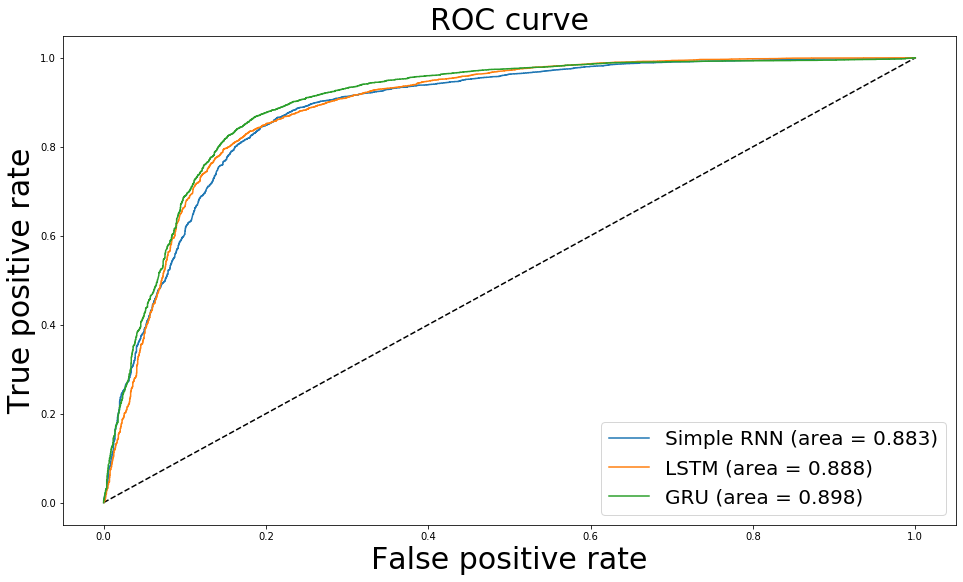

In [95]:
plt.figure(1,figsize=(16,9))
plt.plot([0, 1], [0, 1], 'k--')
for i,model in enumerate(models):
    fpr_keras, tpr_keras, auc_keras=get_roc(model)
    plt.plot(fpr_keras, tpr_keras, label='{0} (area = {1:.3f})'.format(names[i],auc_keras))
plt.xlabel('False positive rate', fontsize= 30)
plt.ylabel('True positive rate', fontsize= 30)
plt.title('ROC curve', fontsize= 30)
plt.legend(loc='best', fontsize= 20)
plt.savefig('results/roc.png')
plt.show()